# Large data set

* DINEOF analysis of Western Mediterranean sea surface temperature.
* Download file and view content of NetCDF file with the following:

In [1]:
using PyPlot
using NCDatasets
Dataset("WesternMedSST.nc")

Dataset: WesternMedSST.nc
Group: /

Dimensions
   lon = 327
   lat = 217
   time = 384

Variables
  lon   (327)
    Datatype:    Float64
    Dimensions:  lon
    Attributes:
     standard_name        = longitude
     units                = degree_east

  lat   (217)
    Datatype:    Float64
    Dimensions:  lat
    Attributes:
     standard_name        = latitude
     units                = degree_north

  time   (384)
    Datatype:    Float64
    Dimensions:  time
    Attributes:
     standard_name        = latitude
     units                = days since 1900-01-01 00:00:00

  seviri_sst   (327 × 217 × 384)
    Datatype:    Float32
    Dimensions:  lon × lat × time
    Attributes:
     standard_name        = sea_water_temperature
     long name            = sea surface temperature
     units                = degree_Celsius
     _FillValue           = -9999.0

  seviri_sst_filled   (327 × 217 × 384)
    Datatype:    Float32
    Dimensions:  lon × lat × time
    Attributes:
     standar

# Useful functions

 * display the content of a NetCDF file.
```julia
Dataset("WesternMedSST.nc")
```

 * Read a variable from a NetCDF file.
```julia
ds = Dataset("WesternMedSST.nc")
SST = ds["seviri_sst_filled"][:]
close(ds)
```

More info at https://github.com/Alexander-Barth/NCDatasets.jl

# Example

Load modules and setup some helper functions

In [48]:
using NCDatasets
using PyPlot

# Helper function for dateticks
function datetick(axis,fmt = "%Y-%m-%d")
    ax = axes()
    formatter = matplotlib[:dates][:DateFormatter](fmt)

    if axis == :x
        ax[:xaxis][:set_major_formatter](formatter)
    else
        ax[:yaxis][:set_major_formatter](formatter)
    end
end



datetick (generic function with 2 methods)

In [52]:
using DelimitedFiles
sl  = readdlm("8762075.sealevel.txt",comments=true, comment_char='%')


8784×8 Array{Float64,2}:
 2004.0   1.0   1.0   0.0  0.0   0.297  0.003  0.0
 2004.0   1.0   1.0   1.0  0.0   0.302  0.002  0.0
 2004.0   1.0   1.0   2.0  0.0   0.295  0.006  0.0
 2004.0   1.0   1.0   3.0  0.0   0.28   0.003  0.0
 2004.0   1.0   1.0   4.0  0.0   0.236  0.004  0.0
 2004.0   1.0   1.0   5.0  0.0   0.192  0.003  0.0
 2004.0   1.0   1.0   6.0  0.0   0.164  0.002  0.0
 2004.0   1.0   1.0   7.0  0.0   0.153  0.003  0.0
 2004.0   1.0   1.0   8.0  0.0   0.126  0.002  0.0
 2004.0   1.0   1.0   9.0  0.0   0.094  0.002  0.0
 2004.0   1.0   1.0  10.0  0.0   0.067  0.002  0.0
 2004.0   1.0   1.0  11.0  0.0   0.069  0.002  0.0
 2004.0   1.0   1.0  12.0  0.0   0.08   0.001  0.0
    ⋮                            ⋮                
 2004.0  12.0  31.0  12.0  0.0   0.078  0.003  0.0
 2004.0  12.0  31.0  13.0  0.0   0.031  0.002  0.0
 2004.0  12.0  31.0  14.0  0.0  -0.002  0.005  0.0
 2004.0  12.0  31.0  15.0  0.0  -0.025  0.001  0.0
 2004.0  12.0  31.0  16.0  0.0  -0.037  0.004  0.0
 2004.

In [54]:
using Dates
DateTime([sl[1,1:5]; 0]...) 


2004-01-01T00:00:00

In [55]:

DateTime(sl[1,1],sl[1,2],sl[1,3],sl[1,4],sl[1,5],0)

2004-01-01T00:00:00

In [56]:
[i^2 for i = 1:10]

10-element Array{Int64,1}:
   1
   4
   9
  16
  25
  36
  49
  64
  81
 100

In [57]:
size(sl,1)

8784

In [58]:
t = [DateTime(sl[i,1],sl[i,2],sl[i,3],sl[i,4],sl[i,5],0) 
    for i = 1:size(sl,1)];


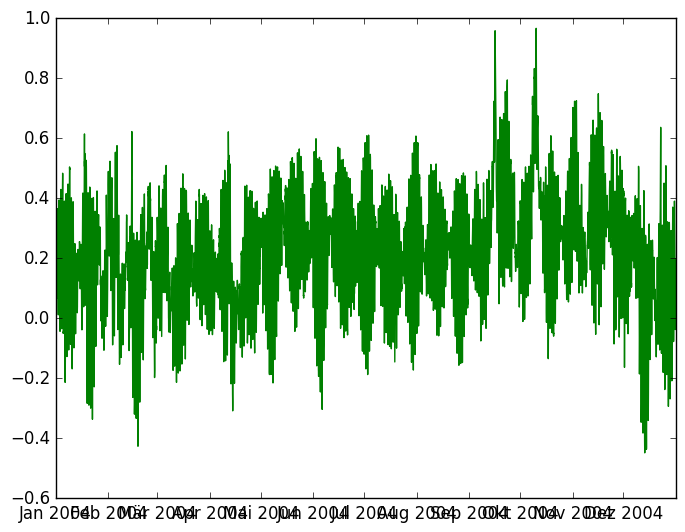

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f1772ea2470>

In [63]:
plot(t[:],sl[:,6],"g")


In [62]:
plot(t,sl[:,6],"g")
ax = axes()
formatter = matplotlib[:dates][:DateFormatter]("%Y-%m")
locator = matplotlib[:dates][:MonthLocator](interval=2)
ax[:xaxis][:set_major_locator](locator)
ax[:xaxis][:set_major_formatter](formatter)



UndefVarError: UndefVarError: axes not defined

In [61]:
fname = "WesternMedSST.nc";
ds = Dataset(fname)
lon = ds["lon"][:];
lat = ds["lat"][:];
time = ds["time"][:];
SST = ds["seviri_sst"][:];
mask = ds["mask"][:];
close(ds)


ErrorException: cannot assign variable Libc.time from module Main

In [12]:
time

time (generic function with 2 methods)

In [13]:
SSTdiff = SST[:,:,2] - SST[:,:,1]
pcolor(lon,lat,SST[:,:,2]'); colorbar()

UndefVarError: UndefVarError: SST not defined

In [14]:
SSTdiff = SST[:,:,2] - SST[:,:,1]
pcolor(lon,lat,SSTdiff'); colorbar()

UndefVarError: UndefVarError: SST not defined

### Plot the first time instance of the data set with pcolor.

In [15]:
ds = Dataset("WesternMedSST.nc")
lon = ds["lon"][:]
lat = ds["lat"][:]
close(ds)

pcolor(lon,lat,SST[:,:,1]')

UndefVarError: UndefVarError: SST not defined

In [16]:
pcolor(lon,lat,SST[:,:,1]');
colorbar()


UndefVarError: UndefVarError: SST not defined

In [17]:
SST[1,1,1]

UndefVarError: UndefVarError: SST not defined

In [18]:
ismissing(SST[1,1,1])

UndefVarError: UndefVarError: SST not defined

In [19]:
k = 1
count = 0
if !ismissing(SST[1,1,k])
    # do something
    count = count+1
end
count

UndefVarError: UndefVarError: SST not defined

### Plot the percentage of valid data grid point over time.

In [20]:
imax = size(SST,1)
jmax = size(SST,2)
kmax = size(SST,3)


UndefVarError: UndefVarError: SST not defined

In [21]:
imax, jmax, kmax = size(SST)

UndefVarError: UndefVarError: SST not defined

In [22]:
nbpixels = zeros(kmax)

for k = 1:kmax
  count = 0

  for j = 1:jmax
    for i = 1:imax
       if !ismissing(SST[i,j,k])
         count = count + 1
       end        
    end
        
    nbpixels[k] = count
  end
end
percentage = 100 * nbpixels/(imax*jmax)


UndefVarError: UndefVarError: kmax not defined

In [23]:
plot(percentage)

UndefVarError: UndefVarError: percentage not defined

In [24]:
sum(sum(.!ismissing.(SST[:,:,1]),1),2)

UndefVarError: UndefVarError: SST not defined

In [25]:

sum(.!ismissing.(SST[:,:,1]),[1,2])

UndefVarError: UndefVarError: SST not defined

In [26]:
count = zeros((imax,jmax))
for j = 1:jmax
    for i = 1:imax
        for k = 1:kmax
            if !ismissing(SST[i,j,k])
                count[i,j] = count[i,j] + 1
            end
        end

        count[i,j] = 100*count[i,j]/kmax
    end
end


UndefVarError: UndefVarError: imax not defined

In [27]:
count = 100 * squeeze(sum(.!ismissing.(SST),3),3) / kmax;


UndefVarError: UndefVarError: SST not defined

In [28]:
pcolor(lon,lat,count'), colorbar()


PyCall.PyError: PyError ($(Expr(:escape, :(ccall(#= /home/abarth/.julia/packages/PyCall/akNFy/src/pyfncall.jl:44 =# @pysym(:PyObject_Call), PyPtr, (PyPtr, PyPtr, PyPtr), o, pyargsptr, kw))))) <class 'ValueError'>
ValueError('not enough values to unpack (expected 2, got 0)',)
  File "/usr/lib/python3/dist-packages/matplotlib/pyplot.py", line 3076, in pcolor
    ret = ax.pcolor(*args, **kwargs)
  File "/usr/lib/python3/dist-packages/matplotlib/__init__.py", line 1814, in inner
    return func(ax, *args, **kwargs)
  File "/usr/lib/python3/dist-packages/matplotlib/axes/_axes.py", line 5193, in pcolor
    X, Y, C = self._pcolorargs('pcolor', *args, allmatch=False)
  File "/usr/lib/python3/dist-packages/matplotlib/axes/_axes.py", line 4995, in _pcolorargs
    numRows, numCols = C.shape


### For all time instances, what is the percentage of sea grid points not covered by clouds?

In [29]:
count = zeros(Int,(kmax,))
for k = 1:kmax
    for j = 1:jmax
        for i = 1:imax
            if !ismissing(SST[i,j,k])
                count[k] = count[k] + 1
            end
        end
    end
end


UndefVarError: UndefVarError: kmax not defined

In [30]:
count[1:4]

MethodError: MethodError: no method matching getindex(::Int64, ::UnitRange{Int64})
Closest candidates are:
  getindex(::Number) at number.jl:75
  getindex(::Number, !Matched::Integer) at number.jl:77
  getindex(::Number, !Matched::Integer...) at number.jl:82
  ...

In [31]:
count = squeeze(sum(sum(.!ismissing.(SST),1),2),(1,2))
count[1:4]

UndefVarError: UndefVarError: SST not defined

In [32]:
percentage = 100 * count / sum(mask)
percentage[1:10]

UndefVarError: UndefVarError: mask not defined

In [33]:
time[1:5]

MethodError: MethodError: no method matching getindex(::typeof(time), ::UnitRange{Int64})

In [34]:
plot(time,percentage)
datetick(:x,"%m-%d")


UndefVarError: UndefVarError: percentage not defined

### Plot the time average of SST

In [35]:
SST2 = copy(SST.data);
SST2[ismissing.(SST)] = 0;
count = sum(.!ismissing.(SST),3)
meanSST = DataArray(sum(SST2,3) ./ count,count .== 0);


pcolor(lon,lat,meanSST[:,:,1]');   colorbar()


UndefVarError: UndefVarError: SST not defined

### Plot the space average of SST 

* assuming that all pixels have the same area

In [36]:
meanSSTt = sum(sum(SST2,1),2) ./ sum(sum(.!ismissing.(SST),1),2);
meanSSTt = squeeze(meanSSTt,(1,2));
plot(time,meanSSTt)
datetick(:x,"%m-%d")


UndefVarError: UndefVarError: SST2 not defined

In [37]:
meanSSTt2 = mean(mean(SST,1,skipna=true),2,skipna=true)
meanSSTt2 = squeeze(meanSSTt2,(1,2));
plot(time,meanSSTt,"b")
plot(time,meanSSTt2,"r")
legend(["result with sum","result with nanmean"]);
datetick(:x,"%m-%d")


UndefVarError: UndefVarError: mean not defined

### Make a time serie with the number of pixels with the temperature larger than 25 degree Celsius.

In [38]:
count = zeros((kmax,))
for k = 1:kmax
    for j = 1:jmax
        for i = 1:imax
            if !ismissing(SST[i,j,k]) && (SST[i,j,k] > 25)
                count[k] = count[k] + 1
            end
        end
    end
end


UndefVarError: UndefVarError: kmax not defined

In [39]:
count[1:5]

MethodError: MethodError: no method matching getindex(::Int64, ::UnitRange{Int64})
Closest candidates are:
  getindex(::Number) at number.jl:75
  getindex(::Number, !Matched::Integer) at number.jl:77
  getindex(::Number, !Matched::Integer...) at number.jl:82
  ...

In [40]:
count = sum(SST .> 25,[1,2],skipmissing = true)
count = squeeze(count,(1,2))


UndefVarError: UndefVarError: SST not defined

In [41]:
count[1:5]

MethodError: MethodError: no method matching getindex(::Int64, ::UnitRange{Int64})
Closest candidates are:
  getindex(::Number) at number.jl:75
  getindex(::Number, !Matched::Integer) at number.jl:77
  getindex(::Number, !Matched::Integer...) at number.jl:82
  ...

In [42]:
plot(time,count)
datetick(:x,"%m-%d")


PyCall.PyError: PyError ($(Expr(:escape, :(ccall(#= /home/abarth/.julia/packages/PyCall/akNFy/src/pyfncall.jl:44 =# @pysym(:PyObject_Call), PyPtr, (PyPtr, PyPtr, PyPtr), o, pyargsptr, kw))))) <class 'RuntimeError'>
RuntimeError('Julia exception: MethodError(iterate, (time,), 0x00000000000061c8)',)
  File "/usr/lib/python3/dist-packages/matplotlib/pyplot.py", line 3154, in plot
    ret = ax.plot(*args, **kwargs)
  File "/usr/lib/python3/dist-packages/matplotlib/__init__.py", line 1814, in inner
    return func(ax, *args, **kwargs)
  File "/usr/lib/python3/dist-packages/matplotlib/axes/_axes.py", line 1424, in plot
    for line in self._get_lines(*args, **kwargs):
  File "/usr/lib/python3/dist-packages/matplotlib/axes/_base.py", line 386, in _grab_next_args
    for seg in self._plot_args(remaining, kwargs):
  File "/usr/lib/python3/dist-packages/matplotlib/axes/_base.py", line 364, in _plot_args
    x, y = self._xy_from_xy(x, y)
  File "/usr/lib/python3/dist-packages/matplotlib/axes/_base.py", line 197, in _xy_from_xy
    bx = self.axes.xaxis.update_units(x)
  File "/usr/lib/python3/dist-packages/matplotlib/axis.py", line 1383, in update_units
    converter = munits.registry.get_converter(data)
  File "/usr/lib/python3/dist-packages/matplotlib/units.py", line 158, in get_converter
    converter = self.get_converter(next_item)
  File "/usr/lib/python3/dist-packages/matplotlib/units.py", line 161, in get_converter
    if converter is None and iterable(x):
  File "/usr/lib/python3/dist-packages/matplotlib/cbook.py", line 690, in iterable
    iter(obj)


### Make a time serie of the area (in km2) with the temperature larger than 25 degree Celsius

In [43]:
# Earth Radius (in km)
R = 6371;
# surface of each cell
dx = pi * 0.05 * R/180;
dy = pi * 0.05 * R/180 * cos.(pi*lat/180);


In [44]:
area = zeros((kmax,))
for k = 1:kmax
    for j = 1:jmax
        for i = 1:imax
            if !ismissing(SST[i,j,k]) && (SST[i,j,k] > 25)
                area[k] = area[k] + dx * dy[j]
            end
        end
    end
end


UndefVarError: UndefVarError: kmax not defined

In [45]:
plot(time,area)
datetick(:x,"%m-%d")


UndefVarError: UndefVarError: area not defined

In [46]:
average = zeros(imax,jmax)
  
for i = 1:imax
    for j = 1:jmax
       mymean = 0.
       count = 0

       for k = 1:kmax
           if !ismissing(SST[i,j,k])
              mymean = mymean + SST[i,j,k]
              count = count+1
            end
        end
        
        mymean = mymean/count
        average[i,j] = mymean   
    end
end



UndefVarError: UndefVarError: imax not defined

In [47]:
pcolor(average'); colorbar()


UndefVarError: UndefVarError: average not defined

Ideas for exercises
* Compute the mean over time for every pixel
* Compute the standard deviation over time for every pixel
* Make a map with the minimum temperature
* Make a map with the time index at which the temperature is minimum
